In [42]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0)

In [43]:
def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    image_tensor = (image_tensor + 1) / 2
    image_unflat = image_tensor.detach().cpu()
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

In [44]:
class Generator(nn.Module): 
    def __init__(self, z_dim=10, im_chan=1, hidden_dim=64):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        # Build the neural network
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.conv1 = nn.ConvTranspose2d(in_channels = z_dim,out_channels = hidden_dim * 4,
                           kernel_size = 3, stride = 2)
        self.b_norm1 = nn.BatchNorm2d(hidden_dim * 4)
        
        self.conv2 = nn.ConvTranspose2d(in_channels = hidden_dim * 4,out_channels = hidden_dim * 2,
                           kernel_size = 4, stride = 1)
        self.b_norm2 = nn.BatchNorm2d(hidden_dim * 2)
        
        self.conv3 = nn.ConvTranspose2d(in_channels = hidden_dim * 2,out_channels = hidden_dim,
                           kernel_size = 3, stride = 2)
        self.b_norm3 = nn.BatchNorm2d(hidden_dim)
        
        self.conv_out = nn.ConvTranspose2d(in_channels = hidden_dim,out_channels = im_chan,
                        kernel_size = 4, stride = 2)

    def unsqueeze_noise(self, noise):
        
        return noise.view(len(noise), self.z_dim, 1, 1)

    def forward(self, noise):
        #import pdb;pdb.set_trace()
        x = self.unsqueeze_noise(noise)
        intermediate1 = self.relu(self.b_norm1(self.conv1(x)))
        intermediate2 = self.relu(self.b_norm2(self.conv2(intermediate1)))
        intermediate3 = self.relu(self.b_norm3(self.conv3(intermediate2)))
        out = self.tanh(self.conv_out(intermediate3))
        return out

In [45]:
def get_noise(n_samples, z_dim, device='cpu'):
    return torch.randn(n_samples, z_dim, device=device)

In [46]:
class Discriminator(nn.Module):
    def __init__(self, im_chan=1, hidden_dim=16):
        super(Discriminator, self).__init__()
                
        self.l_relu = nn.LeakyReLU(0.2)
        
        self.conv1 = nn.utils.spectral_norm(nn.Conv2d(im_chan,hidden_dim,kernel_size = 4,stride = 2))
        self.b_norm1 = nn.BatchNorm2d(hidden_dim)
        
        self.conv2 = nn.utils.spectral_norm(nn.Conv2d(hidden_dim,hidden_dim*2,kernel_size = 4,stride = 2))
        self.b_norm2 = nn.BatchNorm2d(hidden_dim*2)

        self.conv_out = nn.utils.spectral_norm(nn.Conv2d(hidden_dim*2,1,kernel_size = 4,stride = 2))
        
    def forward(self, image):
        #import pdb;pdb.set_trace()
        intermediate1 = self.l_relu(self.b_norm1(self.conv1(image)))
        intermediate2 = self.l_relu(self.b_norm2(self.conv2(intermediate1)))
        out = self.conv_out(intermediate2)
        return out.view(len(out), -1)

In [47]:
criterion = nn.BCEWithLogitsLoss()
n_epochs = 50
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.0002

4
beta_1 = 0.5 
beta_2 = 0.999
device = 'cuda'

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

dataloader = DataLoader(
    MNIST(".", download=True, transform=transform),
    batch_size=batch_size,
    shuffle=True)

In [48]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr, betas=(beta_1, beta_2))
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr, betas=(beta_1, beta_2))

def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)
gen = gen.apply(weights_init)
disc = disc.apply(weights_init)

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 500: Generator loss: 0.694536092638969, discriminator loss: 0.6960722892284388


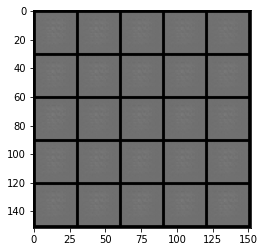

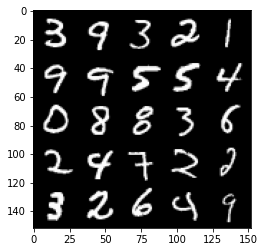

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1000: Generator loss: 0.6932854037284853, discriminator loss: 0.6932020076513289


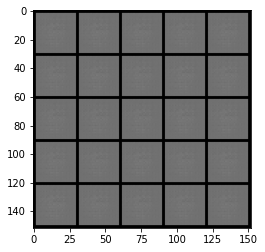

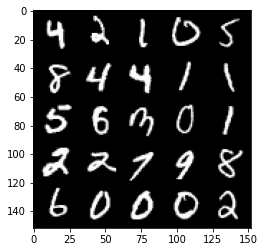

  0%|          | 0/469 [00:00<?, ?it/s]

Step 1500: Generator loss: 0.6932690789699553, discriminator loss: 0.6931737240552905


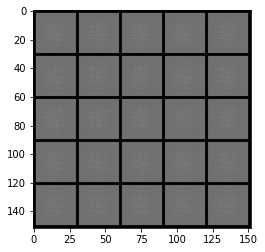

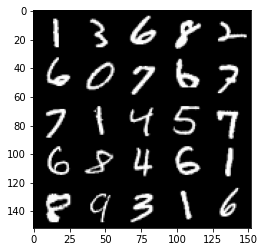

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2000: Generator loss: 0.6933669744729997, discriminator loss: 0.693203259825706


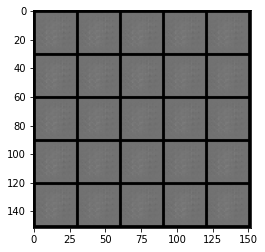

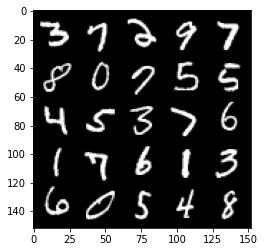

  0%|          | 0/469 [00:00<?, ?it/s]

Step 2500: Generator loss: 0.693333286881447, discriminator loss: 0.6931950985193255


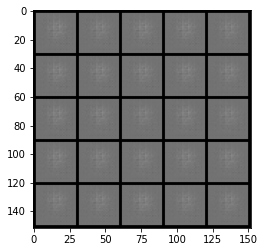

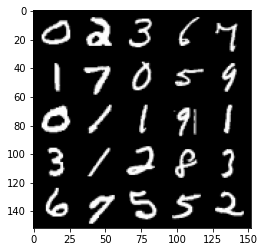

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3000: Generator loss: 0.6936016743183134, discriminator loss: 0.6932788112163543


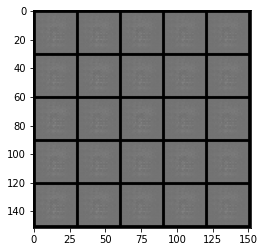

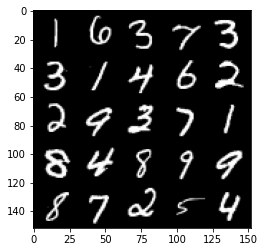

  0%|          | 0/469 [00:00<?, ?it/s]

Step 3500: Generator loss: 0.6932397505044942, discriminator loss: 0.6931709440946577


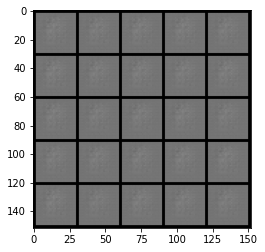

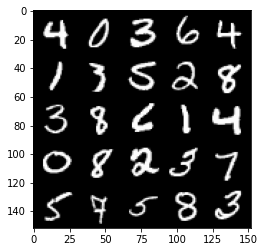

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4000: Generator loss: 0.6932637652158736, discriminator loss: 0.6931850998401651


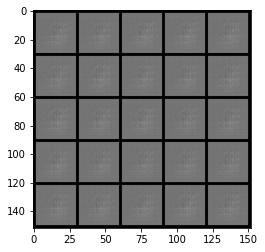

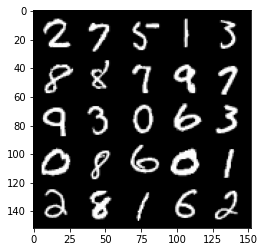

  0%|          | 0/469 [00:00<?, ?it/s]

Step 4500: Generator loss: 0.69346513569355, discriminator loss: 0.6931724261045464


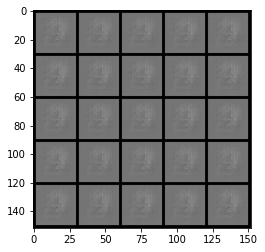

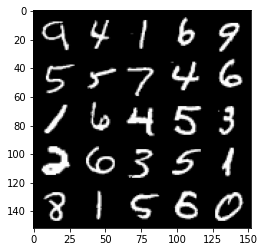

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5000: Generator loss: 0.6934090684652328, discriminator loss: 0.6932138594388958


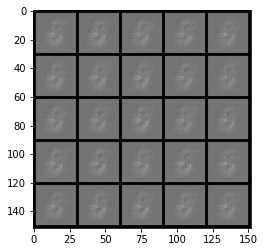

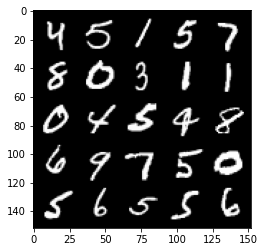

  0%|          | 0/469 [00:00<?, ?it/s]

Step 5500: Generator loss: 0.6933113498687752, discriminator loss: 0.6931856052875511


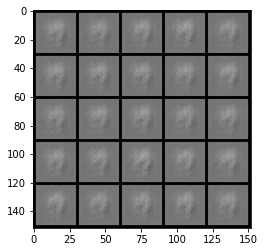

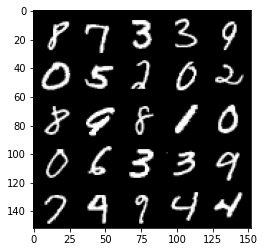

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6000: Generator loss: 0.6932017085552223, discriminator loss: 0.6930180019140244


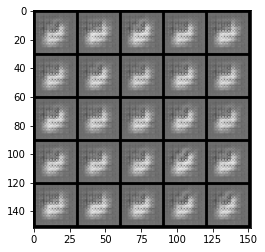

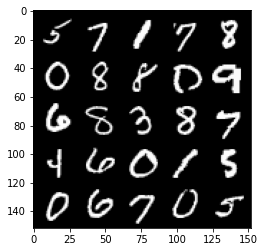

  0%|          | 0/469 [00:00<?, ?it/s]

Step 6500: Generator loss: 0.7171237905025486, discriminator loss: 0.6807167019844056


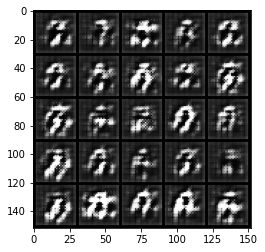

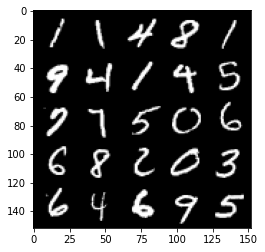

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7000: Generator loss: 0.716899410843849, discriminator loss: 0.6819355653524402


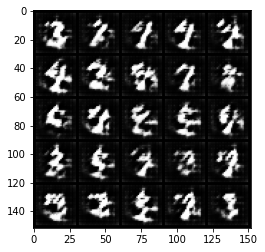

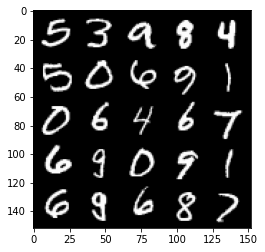

  0%|          | 0/469 [00:00<?, ?it/s]

Step 7500: Generator loss: 0.7091048439741138, discriminator loss: 0.6841110365390776


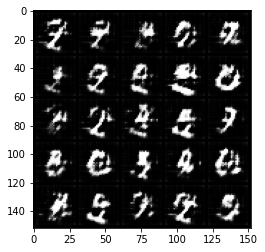

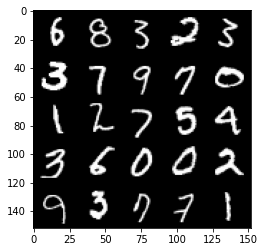

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8000: Generator loss: 0.7096199054718014, discriminator loss: 0.6867139525413514


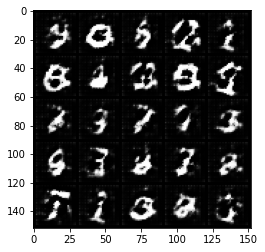

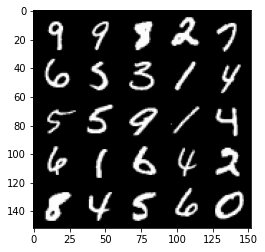

  0%|          | 0/469 [00:00<?, ?it/s]

Step 8500: Generator loss: 0.7053427705764769, discriminator loss: 0.6875638393163682


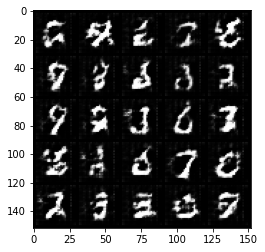

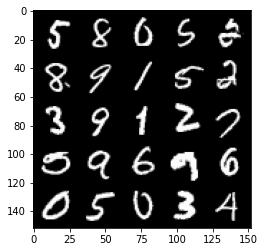

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9000: Generator loss: 0.7025735462903975, discriminator loss: 0.6891269447803502


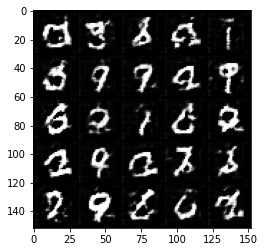

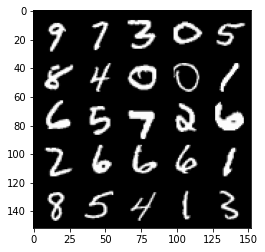

  0%|          | 0/469 [00:00<?, ?it/s]

Step 9500: Generator loss: 0.7006054774522784, discriminator loss: 0.6904090176820751


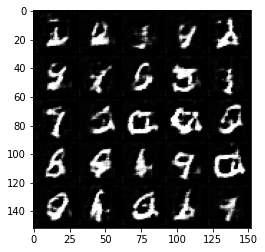

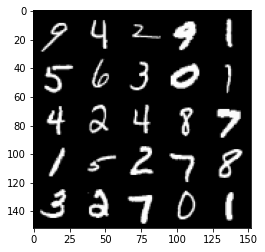

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10000: Generator loss: 0.7006547061204912, discriminator loss: 0.6903797079324729


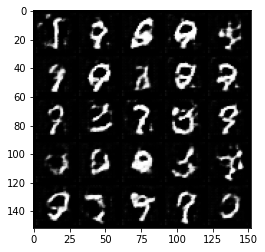

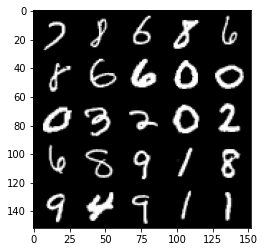

  0%|          | 0/469 [00:00<?, ?it/s]

Step 10500: Generator loss: 0.7016314580440526, discriminator loss: 0.6904243714809415


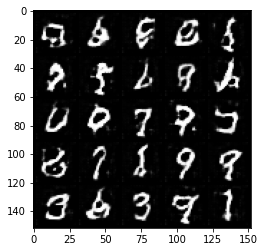

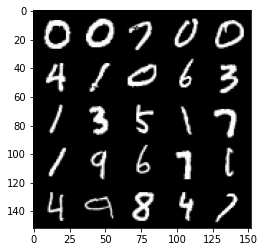

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11000: Generator loss: 0.6994884994030007, discriminator loss: 0.6911381038427357


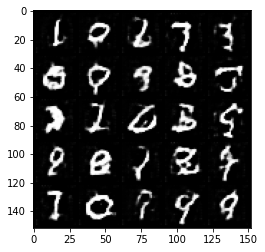

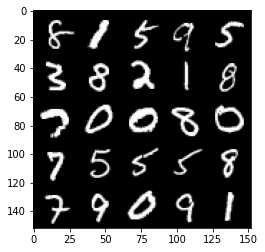

  0%|          | 0/469 [00:00<?, ?it/s]

Step 11500: Generator loss: 0.6999948123693472, discriminator loss: 0.6915741349458686


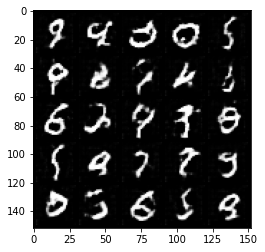

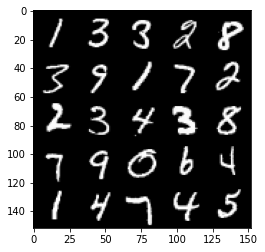

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12000: Generator loss: 0.6976278077363967, discriminator loss: 0.6921937943696976


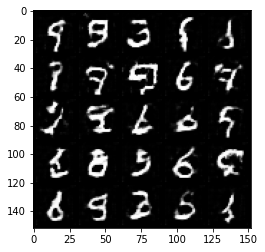

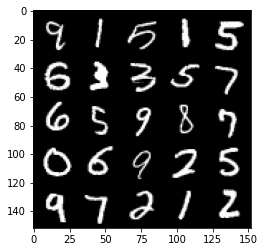

  0%|          | 0/469 [00:00<?, ?it/s]

Step 12500: Generator loss: 0.6963650209903721, discriminator loss: 0.6925499292612078


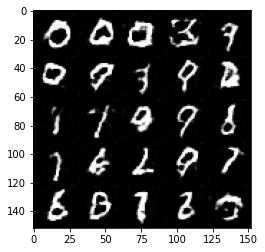

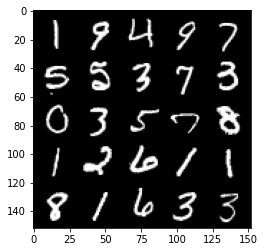

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13000: Generator loss: 0.6967950007915501, discriminator loss: 0.6929039864540097


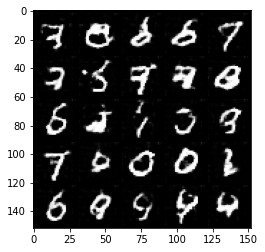

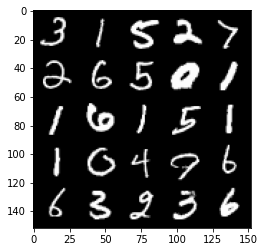

  0%|          | 0/469 [00:00<?, ?it/s]

Step 13500: Generator loss: 0.6954565451145169, discriminator loss: 0.6931880061626436


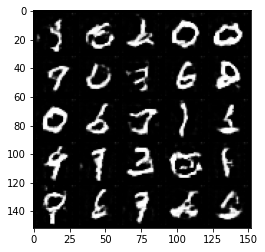

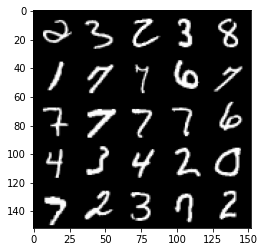

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14000: Generator loss: 0.6948048987388619, discriminator loss: 0.6935539045333863


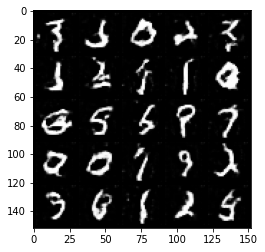

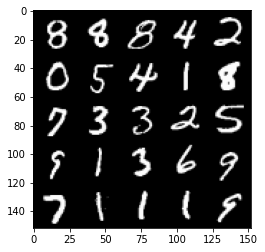

  0%|          | 0/469 [00:00<?, ?it/s]

Step 14500: Generator loss: 0.6958685514926903, discriminator loss: 0.6937552195787429


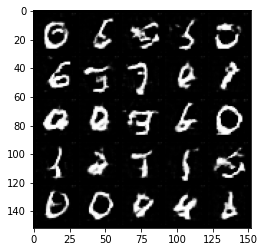

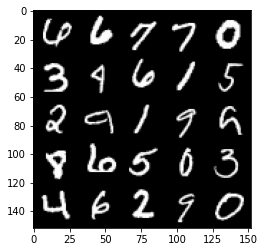

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15000: Generator loss: 0.6948663905858998, discriminator loss: 0.6937588332891464


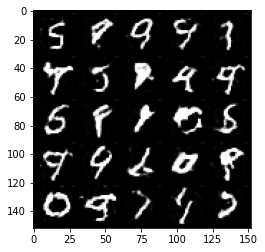

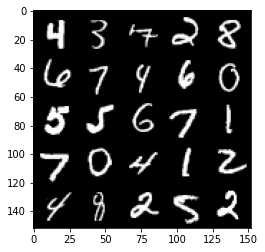

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 15500: Generator loss: 0.6949138174057007, discriminator loss: 0.6937101552486424


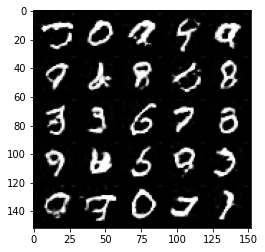

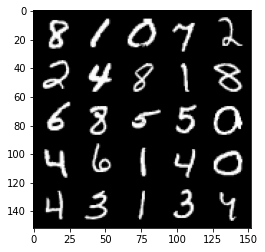

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16000: Generator loss: 0.6946045650243755, discriminator loss: 0.6938159601688387


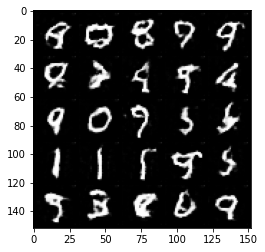

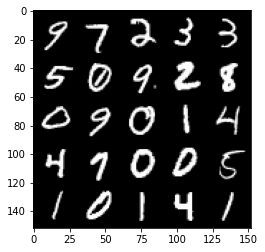

  0%|          | 0/469 [00:00<?, ?it/s]

Step 16500: Generator loss: 0.6946648041009904, discriminator loss: 0.6938364955186843


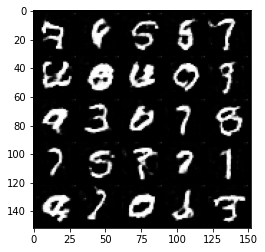

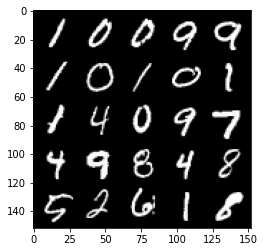

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17000: Generator loss: 0.6946492259502414, discriminator loss: 0.6938675085306167


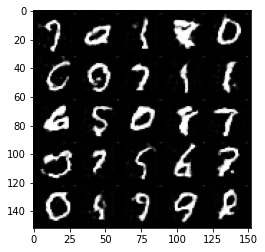

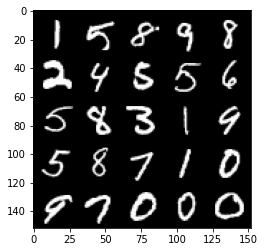

  0%|          | 0/469 [00:00<?, ?it/s]

Step 17500: Generator loss: 0.6946139116287228, discriminator loss: 0.6939197220802308


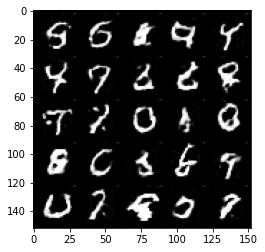

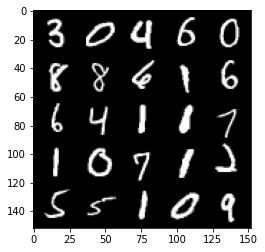

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18000: Generator loss: 0.6949641737937926, discriminator loss: 0.6938012609481811


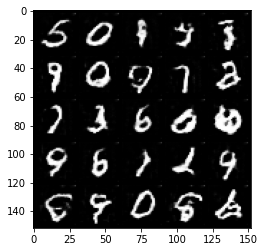

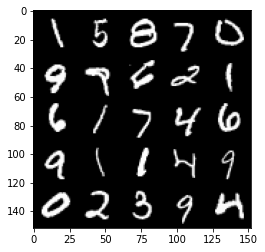

  0%|          | 0/469 [00:00<?, ?it/s]

Step 18500: Generator loss: 0.6939720671176908, discriminator loss: 0.6938487054109579


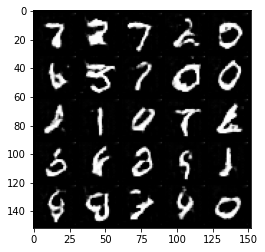

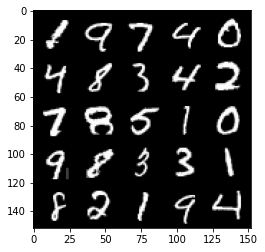

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19000: Generator loss: 0.6946993759870532, discriminator loss: 0.6938116407394409


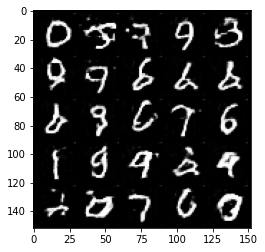

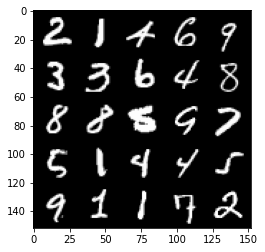

  0%|          | 0/469 [00:00<?, ?it/s]

Step 19500: Generator loss: 0.693773880600929, discriminator loss: 0.6937400186061858


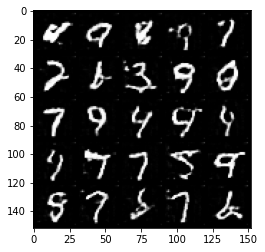

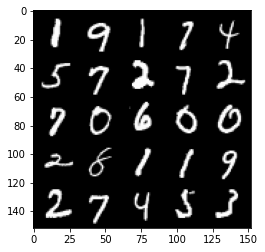

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20000: Generator loss: 0.6945617791414261, discriminator loss: 0.6938056912422182


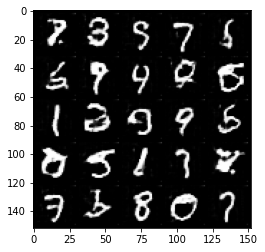

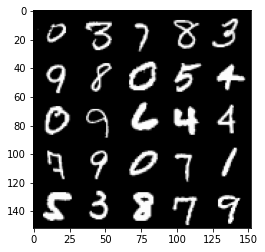

  0%|          | 0/469 [00:00<?, ?it/s]

Step 20500: Generator loss: 0.6937652456760404, discriminator loss: 0.6936508072614677


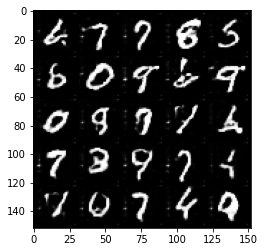

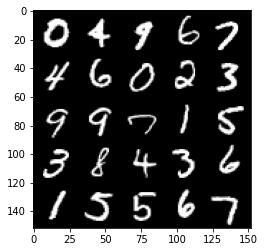

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21000: Generator loss: 0.6935923273563382, discriminator loss: 0.693588819026947


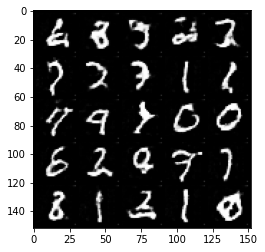

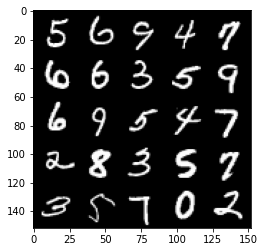

  0%|          | 0/469 [00:00<?, ?it/s]

Step 21500: Generator loss: 0.6945631661415103, discriminator loss: 0.6937122704982751


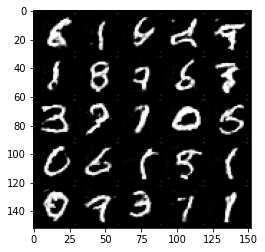

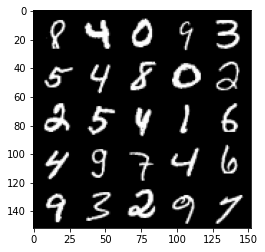

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22000: Generator loss: 0.6936071773767469, discriminator loss: 0.6935567710399629


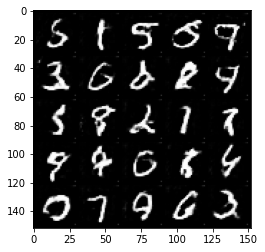

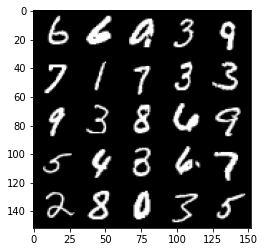

  0%|          | 0/469 [00:00<?, ?it/s]

Step 22500: Generator loss: 0.6938164882659914, discriminator loss: 0.6935929994583132


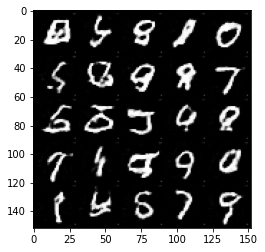

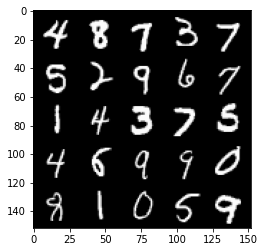

  0%|          | 0/469 [00:00<?, ?it/s]

  0%|          | 0/469 [00:00<?, ?it/s]

Step 23000: Generator loss: 0.6930937402248388, discriminator loss: 0.6934644316434861


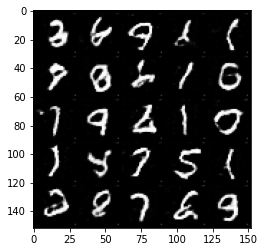

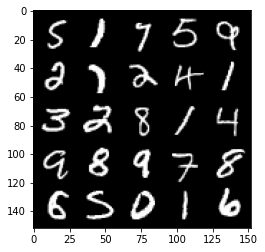

In [49]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    # Dataloader returns the batches
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)
        real = real.to(device)

        ## Update Discriminator ##
        disc_opt.zero_grad()
        fake_noise = get_noise(cur_batch_size, z_dim, device=device)
        fake = gen(fake_noise)
        disc_fake_pred = disc(fake.detach())
        disc_fake_loss = criterion(disc_fake_pred, torch.zeros_like(disc_fake_pred))
        disc_real_pred = disc(real)
        disc_real_loss = criterion(disc_real_pred, torch.ones_like(disc_real_pred))
        disc_loss = (disc_fake_loss + disc_real_loss) / 2

        # Keep track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step
        # Update gradients
        disc_loss.backward(retain_graph=True)
        # Update optimizer
        disc_opt.step()

        ## Update Generator ##
        gen_opt.zero_grad()
        fake_noise_2 = get_noise(cur_batch_size, z_dim, device=device)
        fake_2 = gen(fake_noise_2)
        disc_fake_pred = disc(fake_2)
        gen_loss = criterion(disc_fake_pred, torch.ones_like(disc_fake_pred))
        gen_loss.backward()
        gen_opt.step()

        # Keep track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ## Visualization code ##
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1